In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

CPU times: user 1.14 s, sys: 370 ms, total: 1.51 s
Wall time: 2.41 s


In [2]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 64, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 64, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(64, 64, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(64, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

BATCH_SIZE=3000
GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(64, 64, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([64, 32, 8])
torch.Size([64])
torch.Size([64, 32, 8])
torch.Size([64])
torch.Size([64, 64, 8])
torch.Size([64])
torch.Size([64, 32,

In [3]:
GEN.load_state_dict(torch.load("GEN_WEIGHT.pkl"))

In [4]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

In [8]:
%%time
class Waveform():
    
    def __init__(self, path=None, select=1, select2=1):
        if path is None:
            raise ValueError("Insert file path!")
        if select is None:
            raise ValueError("Pick 1 or 2!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,pedestal,pedestal_sum
        initial = waveform_n[label==select]
        del waveform_n, label
        version2 = initial[label2==select2]
        del initial, label2
        self.waveform = version2[survives==0]
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root",select=4)

CPU times: user 41 s, sys: 3.17 s, total: 44.2 s
Wall time: 44.1 s


In [9]:
print(len(dataset))
data_loader = DataLoader(dataset=dataset,
                         batch_size=3000,
                         shuffle=False,
                         num_workers=3)
del dataset

19589


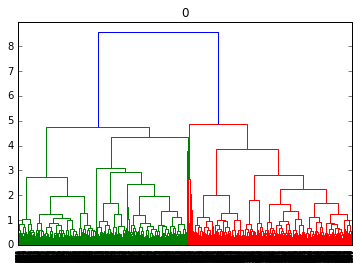

[1 2]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


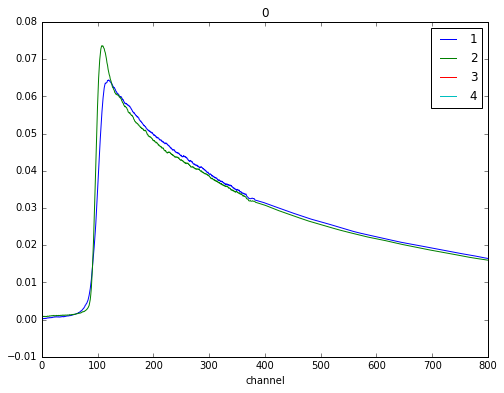

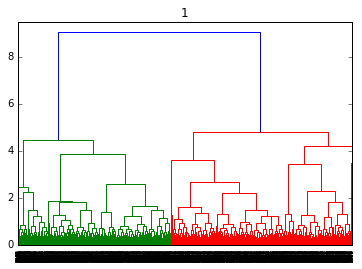

[1 2]


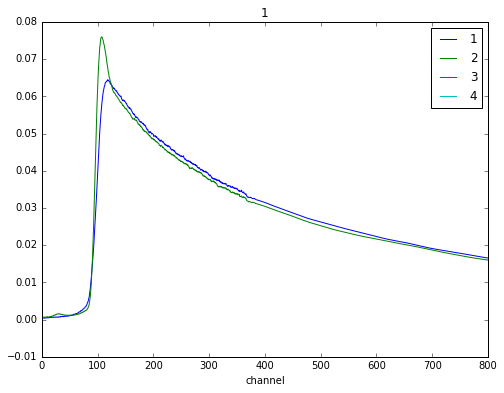

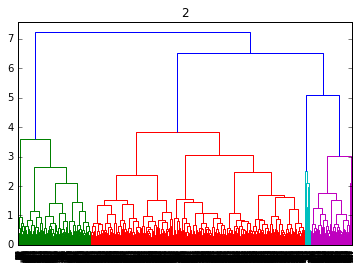

[1 2 3]


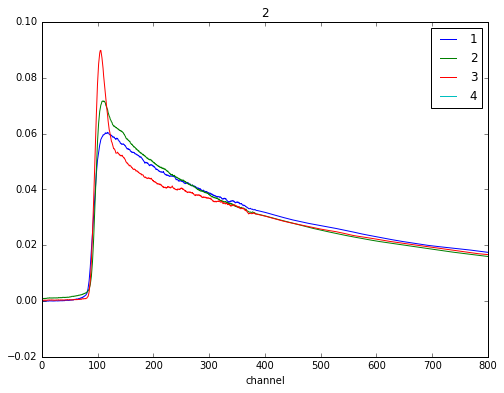

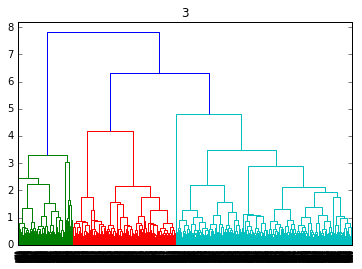

[1 2 3]


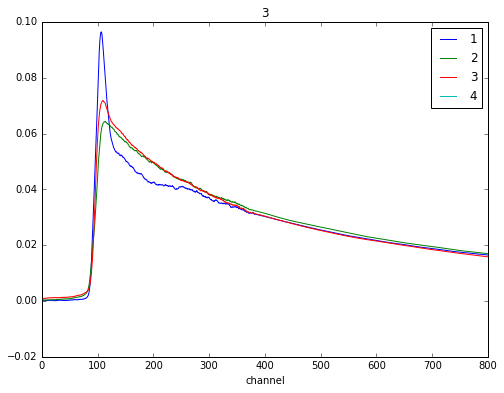

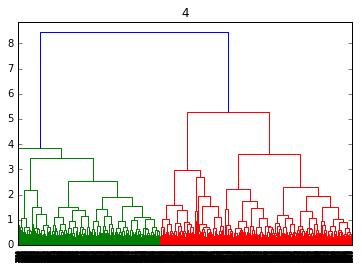

[1 2]


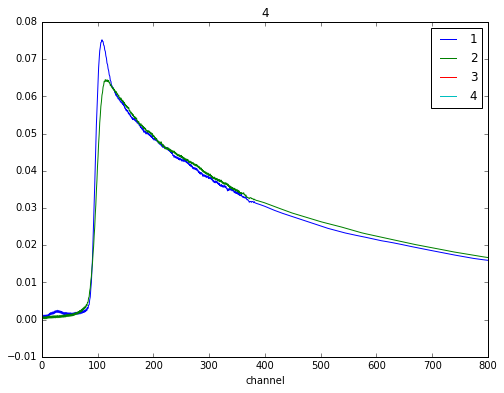

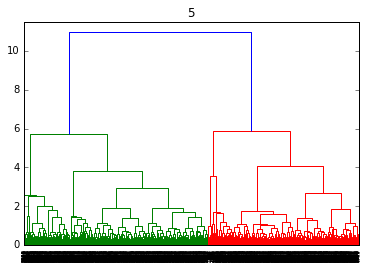

[1 2]


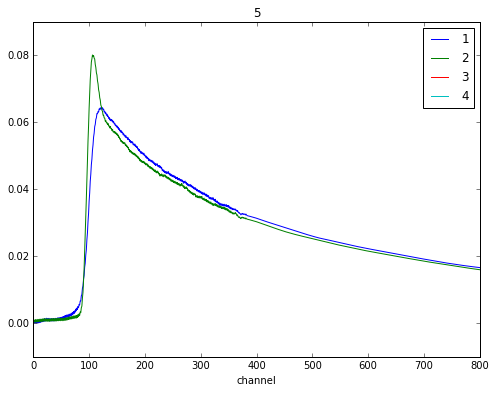

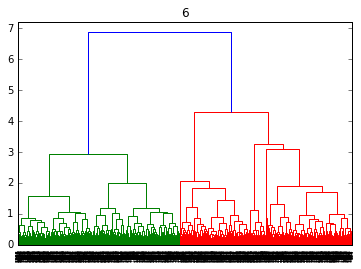

[1 2]


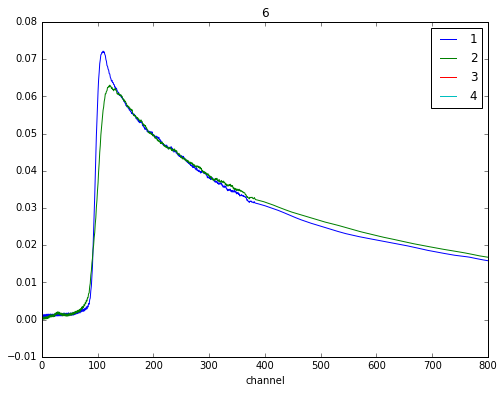

CPU times: user 3min 3s, sys: 22.2 s, total: 3min 25s
Wall time: 3min 10s


In [12]:
%%time

exclude = []

try:
    for batch_number, waveform in enumerate(data_loader):
        
        average = []
        average2 = []
        average3 = []
        average4 = []
        
        batch_size = waveform.size()[0]
        plotter = waveform.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
        fig = plt.figure(figsize=(6, 4))
        dn = dendrogram(Z)
        plt.title("{}".format(batch_number))
        plt.show()
        
        clusters = fcluster(Z, 6, criterion='distance')
        print(np.unique(clusters))
        exclude.append(clusters)
        
        
        for i, waveform_out in enumerate(features[0]):
#             plt.figure(figsize=(6, 4))
#             plt.plot(plotter[i])
#             plt.show()
            if clusters[i]==1:
                average.append(plotter[i])
                
            if clusters[i]==2:
                average2.append(plotter[i])
            
            if clusters[i]==3:
                average3.append(plotter[i])
                
            if clusters[i]==4:
                average4.append(plotter[i])
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
        plt.plot(dang4,label="4")
        plt.xlim(0,800)
        plt.xlabel("channel")
        plt.legend()
        plt.title(batch_number)
        plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')

In [13]:
rid = np.array([2,2,3,1,1,2,1])
remain = np.zeros(19589)
for i,j in enumerate(exclude):
    for k in range(len(j)):
        if exclude[i][k]==rid[i]:
            remain[(i*3000+k)] = 1

In [15]:
remain = remain.astype(int)

In [18]:
np.save("final",remain)

In [24]:
%%time
class Waveform():
    
    def __init__(self, path=None, select=1, select2=1):
        if path is None:
            raise ValueError("Insert file path!")
        if select is None:
            raise ValueError("Pick 1 or 2!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,pedestal,pedestal_sum
        initial = waveform_n[label==select]
        del waveform_n, label
        version2 = initial[label2==select2]
        del initial, label2
        version3 = version2[survives==0]
        del version2,survives
        self.waveform = version3[remain==1]
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root",select=4)
print(len(dataset))

7416
CPU times: user 41.1 s, sys: 3.07 s, total: 44.2 s
Wall time: 44.2 s


In [25]:
data_loader = DataLoader(dataset=dataset,
                         batch_size=4000,
                         shuffle=False,
                         num_workers=3)
del dataset

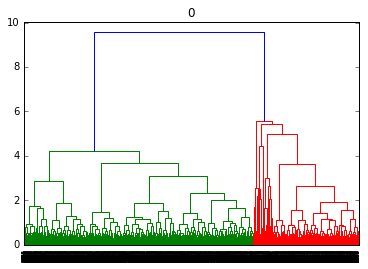

[1 2 3 4]


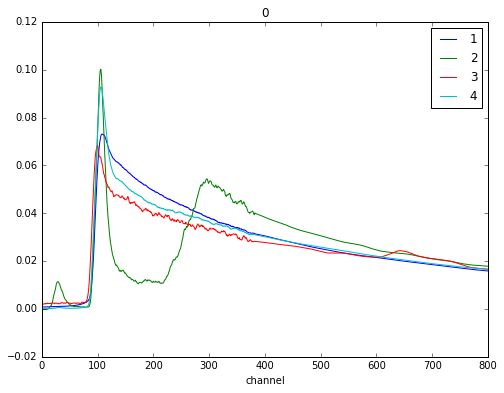

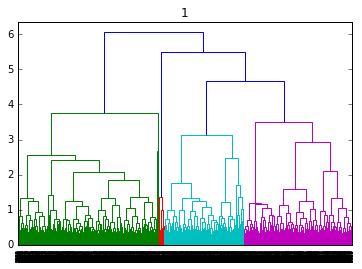

[1 2 3]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


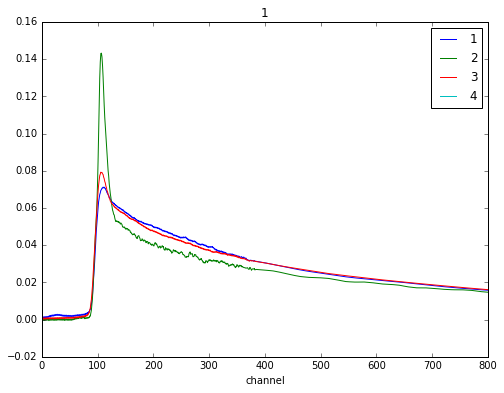

CPU times: user 1min 9s, sys: 9.68 s, total: 1min 19s
Wall time: 1min 14s


In [28]:
%%time
refine = []

try:
    for batch_number, waveform in enumerate(data_loader):
        
        average = []
        average2 = []
        average3 = []
        average4 = []
        
        batch_size = waveform.size()[0]
        plotter = waveform.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
        fig = plt.figure(figsize=(6, 4))
        dn = dendrogram(Z)
        plt.title("{}".format(batch_number))
        plt.show()
        
        clusters = fcluster(Z, 5, criterion='distance')
        print(np.unique(clusters))
        refine.append(clusters)
        
        
        for i, waveform_out in enumerate(features[0]):
#             plt.figure(figsize=(6, 4))
#             plt.plot(plotter[i])
#             plt.show()
            if clusters[i]==1:
                average.append(plotter[i])
                
            if clusters[i]==2:
                average2.append(plotter[i])
            
            if clusters[i]==3:
                average3.append(plotter[i])
                
            if clusters[i]==4:
                average4.append(plotter[i])
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
        plt.plot(dang4,label="4")
        plt.xlim(0,800)
        plt.xlabel("channel")
        plt.legend()
        plt.title(batch_number)
        plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')

In [29]:
leftover = np.zeros(7416)
for i,j in enumerate(refine):
    for k in range(len(j)):
        if refine[i][k] == 1:
            leftover[(i*4000+k)] = 1

In [31]:
leftover = leftover.astype(int)

In [32]:
np.save("final_final",leftover)

In [35]:
%%time
class Waveform():
    
    def __init__(self, path=None, select=1, select2=1):
        if path is None:
            raise ValueError("Insert file path!")
        if select is None:
            raise ValueError("Pick 1 or 2!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        final = np.load("final.npy")
        
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,pedestal,pedestal_sum
        initial = waveform_n[label==select]
        del waveform_n, label
        version2 = initial[label2==select2]
        del initial, label2
        version3 = version2[survives==0]
        del version2,survives
        version4 = version3[final==1]
        self.waveform = version4[leftover==1]
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root",select=4)
print(len(dataset))

4181
CPU times: user 44.7 s, sys: 3.43 s, total: 48.1 s
Wall time: 48.1 s


In [36]:
data_loader = DataLoader(dataset=dataset,
                         batch_size=5000,
                         shuffle=False,
                         num_workers=3)
del dataset

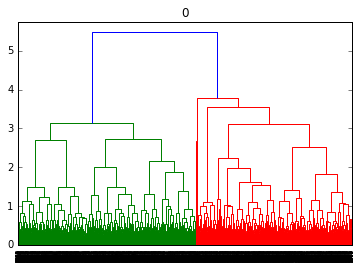

[1 2 3 4 5 6]


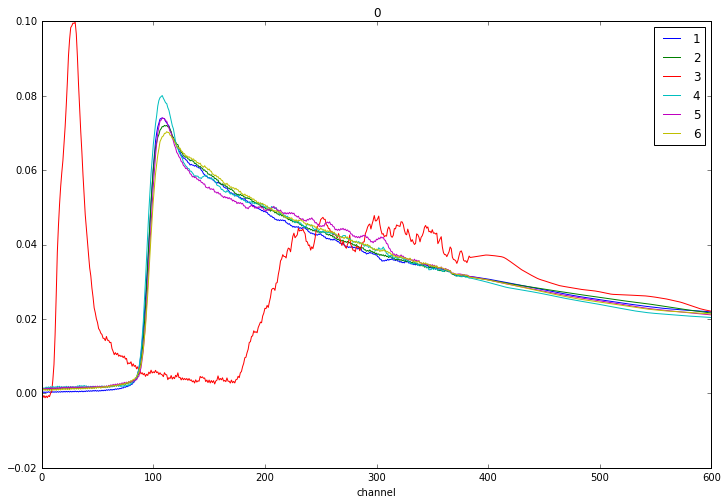

CPU times: user 41.8 s, sys: 5.19 s, total: 47 s
Wall time: 44.8 s


In [44]:
%%time
refine = []

try:
    for batch_number, waveform in enumerate(data_loader):
        
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []
        average6 = []
        
        batch_size = waveform.size()[0]
        plotter = waveform.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
        fig = plt.figure(figsize=(6, 4))
        dn = dendrogram(Z)
        plt.title("{}".format(batch_number))
        plt.show()
        
        clusters = fcluster(Z, 3, criterion='distance')
        print(np.unique(clusters))
        refine.append(clusters)
        
        
        for i, waveform_out in enumerate(features[0]):
#             plt.figure(figsize=(6, 4))
#             plt.plot(plotter[i])
#             plt.show()
            if clusters[i]==1:
                average.append(plotter[i])
                
            if clusters[i]==2:
                average2.append(plotter[i])
            
            if clusters[i]==3:
                average3.append(plotter[i])
                
            if clusters[i]==4:
                average4.append(plotter[i])
                
            if clusters[i]==5:
                average5.append(plotter[i])
                
            if clusters[i]==6:
                average6.append(plotter[i])
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
        dang5 = np.mean(average5, axis=0)
        dang6 = np.mean(average6, axis=0)
        
        plt.figure(figsize=(12,8))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
        plt.plot(dang4,label="4")
        plt.plot(dang5,label="5")
        plt.plot(dang6,label="6")
        plt.xlim(0,600)
        plt.xlabel("channel")
        plt.legend()
        plt.title(batch_number)
        plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')

In [48]:
refine = refine[0]
print(refine)

[1 2 1 ... 6 6 1]


In [69]:
really_final = np.ones(4181)
for i,j in enumerate(refine):
    if refine[i] == 3:
        really_final[i] = 0
    

In [72]:
print(really_final[:1000])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [71]:
really_final = really_final.astype(int)

In [73]:
np.save("really_final",really_final)

In [78]:
%%time
class Waveform():
    
    def __init__(self, path=None, select=1, select2=1):
        if path is None:
            raise ValueError("Insert file path!")
        if select is None:
            raise ValueError("Pick 1 or 2!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        final = np.load("final.npy")
        final_final = np.load("final_final.npy")
        really_final = np.load("really_final.npy")
        
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,pedestal,pedestal_sum
        initial = waveform_n[label==select]
        del waveform_n, label
        version2 = initial[label2==select2]
        del initial, label2
        version3 = version2[survives==0]
        del version2,survives
        version4 = version3[final==1]
        del version3,final
        version5 = version4[final_final==1]
        del version4,final_final
        self.waveform = version5[really_final==1]
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root",select=4)
print(len(dataset))

4168
CPU times: user 45.6 s, sys: 4.75 s, total: 50.3 s
Wall time: 55 s


In [79]:
data_loader = DataLoader(dataset=dataset,
                         batch_size=5000,
                         shuffle=True,
                         num_workers=3)
del dataset

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


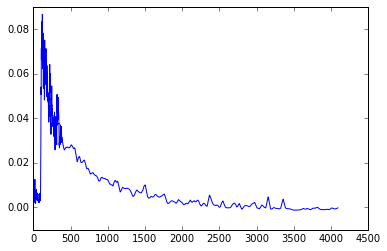

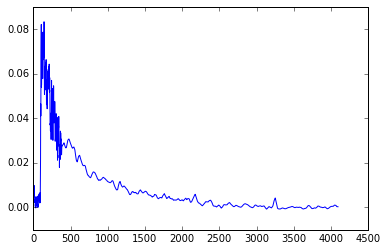

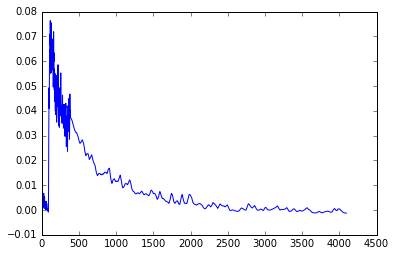

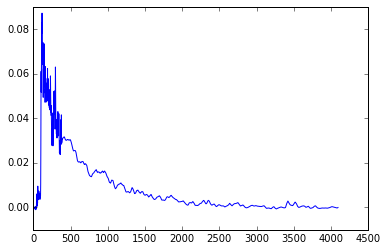

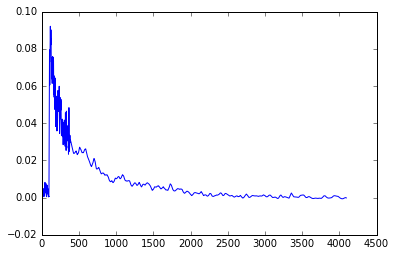

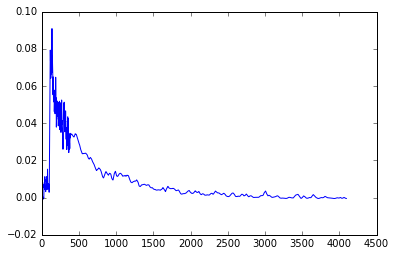

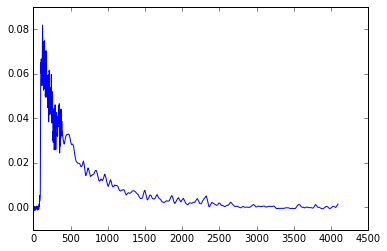

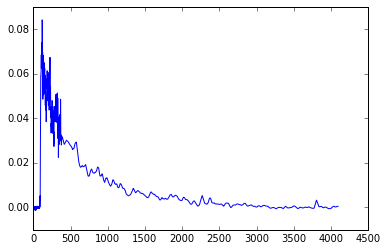

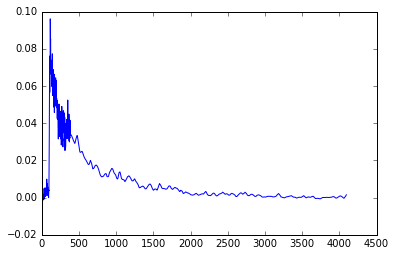

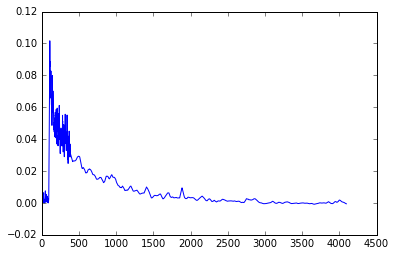

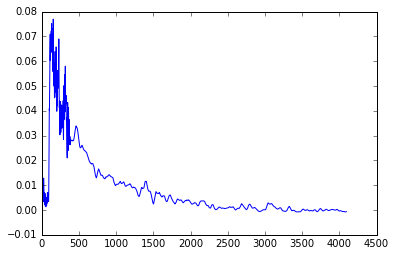

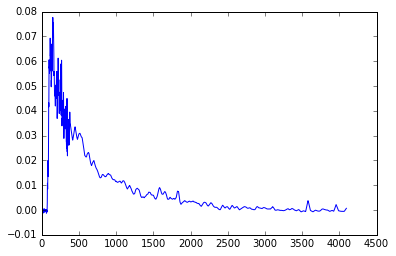

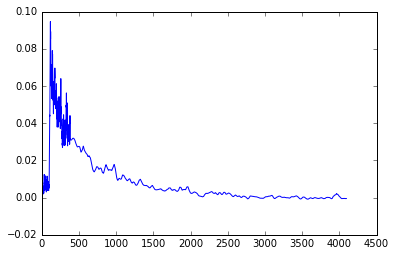

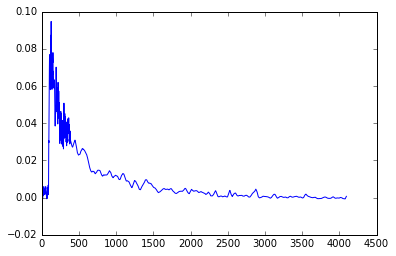

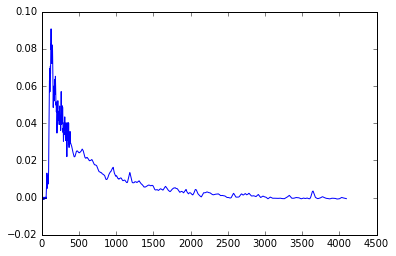

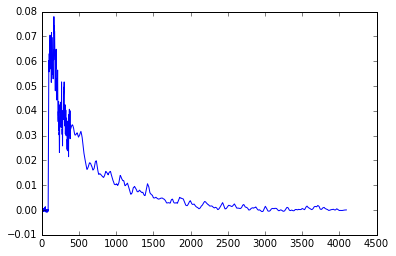

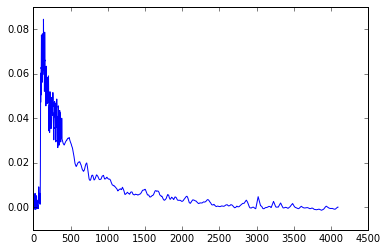

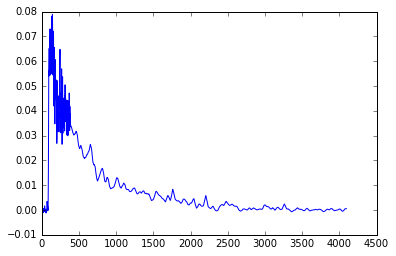

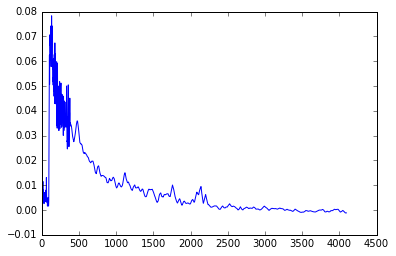

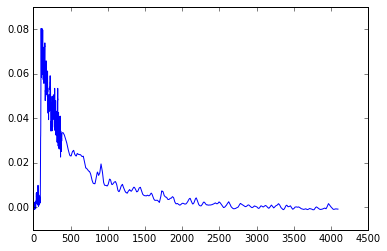

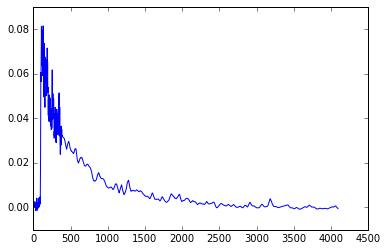

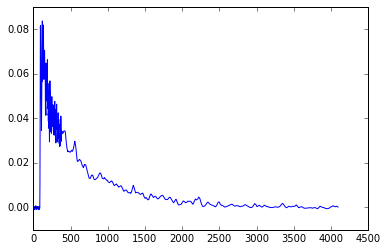

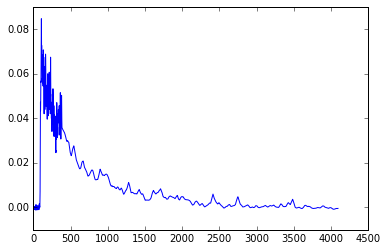

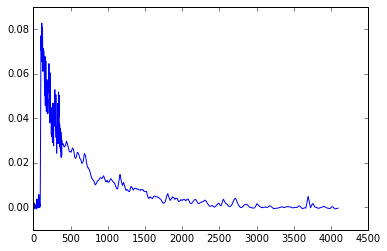

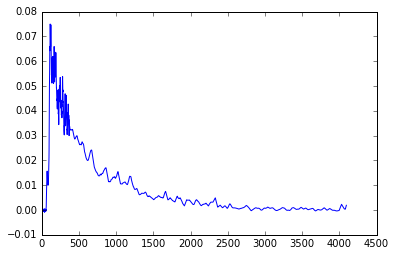

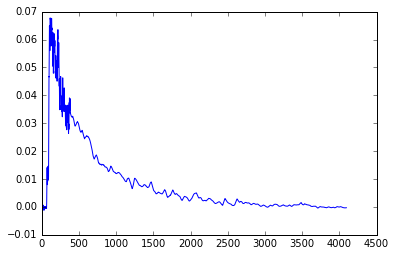

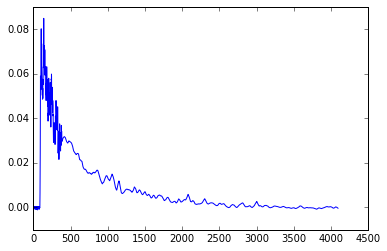

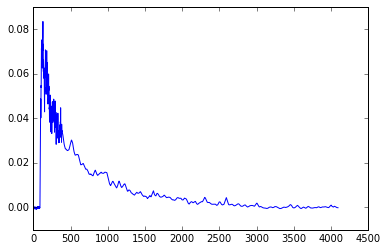

CPU times: user 24.7 s, sys: 4.75 s, total: 29.5 s
Wall time: 26.3 s


In [126]:
%%time
# refine = []

try:
    for batch_number, waveform in enumerate(data_loader):
        
        average = []
        average2 = []
        average3 = []
        average4 = []
        
        batch_size = waveform.size()[0]
        plotter = waveform.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
#         fig = plt.figure(figsize=(6, 4))
#         dn = dendrogram(Z)
#         plt.title("{}".format(batch_number))
#         plt.show()
        
        clusters = fcluster(Z, 1, criterion='distance')
        print(np.unique(clusters))
#         refine.append(clusters)
        
        
        for i, waveform_out in enumerate(features[0]):
            if clusters[i]==20:
                plt.figure(figsize=(6, 4))
                plt.plot(plotter[i])
                plt.show()
#             if clusters[i]==9:
#                 average.append(plotter[i])
#             if clusters[i]==10:
#                 average2.append(plotter[i])
#             if clusters[i]==11:
#                 average3.append(plotter[i])
#             if clusters[i]==12:
#                 average4.append(plotter[i])
                
            
#         dang = np.mean(average, axis=0)
#         dang2 = np.mean(average2, axis=0)
#         dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
        
        
#         plt.figure(figsize=(12,8))
#         plt.plot(dang,label="1")
#         plt.plot(dang2,label="2")
#         plt.plot(dang3,label="3")
#         plt.plot(dang4,label="4")
#         plt.xlim(80,150)
#         plt.xlabel("channel")
#         plt.legend()
#         plt.title(batch_number)
#         plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')